# Homework 6: Reinforcement Learning

## Task 1 (50 points): Formulating Real World Problems as MDPs

#### Prompt
We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

#### Response

## Task 2 (50 points): Reinforcement Learning in concrete domains

#### Prompt
RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

#### Response

## Task 3 (100 points): Implementation of Q-Learning for Tik Tak Toe.

#### Prompt
Implement the game of tic-tac-toe (write a class that implements an agent
playing Tic Tac Toe and learning its Q function) using the Q-learning technique (see the
resources/links provided in class for more details). Clearly describe your evaluation metric and
demonstrate a few runs. You might need to use some online resources to proceed on this. Do
not forget to cite those.

#### Response
One of the main resources I used was [this article](https://towardsdatascience.com/reinforcement-learning-q-learning-with-illegal-actions-from-scratch-19759146c8bf), which describes how you should do Q-learning when your available actions are limited on a state by state basis. I.E., in tic-tak-toe, you are not allowed to put a mark on top of another mark. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:


actionNames = {
    0: "(0, 0) Upper Left",
    1: "(1, 0) Upper Center",
    2: "(2, 0) Upper Right",
    3: "(0, 1) Middle Left",
    4: "(1, 1) Middle Center",
    5: "(2, 1) Middle Right",
    6: "(0, 2) Lower Left",
    7: "(1, 2) Lower Center",
    8: "(2, 2) Lower Right",
}

actions = actionNames.keys()

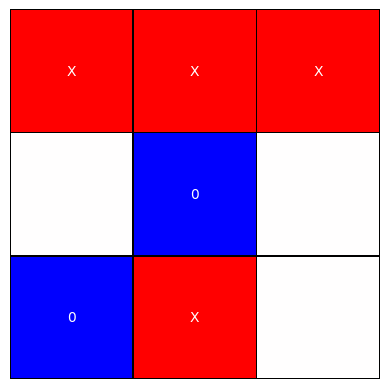

In [19]:
#Board drawing utility
def drawBoard(board, saveName=None):
    labelMap = np.vectorize(lambda value: {1:"X", -1:"0", 0:" "}[value])
    shapedBoard = np.reshape(board, (3, 3))
    labels = labelMap(shapedBoard)
    sns.heatmap(shapedBoard, cmap="bwr", annot=labels, 
        linewidth=.5, linecolor="black", fmt="", cbar=False,
        square=True, xticklabels=False, yticklabels=False)
    if saveName:
        plt.savefig(f"figs/{saveName}")

#Testing
drawBoard([1, 1, 1, 0, -1, 0, -1, 1, 0])

In [66]:
#Instead of a tik tak toe class, we pre-generate the whole game tree to speed up checking the winner since ticktacktoe is a reasonably small game

#Maps board arrays to states to save us space, we reuse state nodes if we encounter a state that already exists
boardToState = {}

class GameStateNode():
    def __init__(self):
        #if we are a termination state (leaf node), self.winner is who won, X or O, else is None if draw or not leaf node
        self.winner = None  
        
        #an dict representing the map between actions the child states
        self.children = {}
        
        #The board representation as an array of 9 positions, we can use this for drawing any state
        #0 represents an empty box, 1 represents a X, -1 represents a 0
        self.board = None


#There are only 8 win masks, faster to index all of them rather than add every time
winMasks = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0], #Horizontal wins
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 1, 0, 0], #Vertical Wins
    [0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1], #Diagonal wins
    [0, 0, 1, 0, 1, 0, 1, 0, 0]
])

def win(board):
    for winMask in winMasks:
        maskedSum = np.sum(winMask*board)
        if maskedSum == 3:
            return "X"
        elif maskedSum == -3:
            return "0"
    return None


def buildGameTree(node, board, player):
    node.winner = win(board)
    if node.winner:             #if the game isn't over, create new branches for all actions
        return
    for action in actions:
        if board[action] == 0:  #if move is legal
            newBoard = np.copy(board)
            newBoard[action] = player
            newBoard.flags.writeable = False
            if newBoard.tobytes() in boardToState:             #Reuse trees for states we've already seen
                newNode = boardToState[newBoard.tobytes()]     
            else:                                                   #Create new tree if we have not seen it
                newNode = GameStateNode()                    
                newNode.board = newBoard
                buildGameTree(newNode, newBoard, -player)
                boardToState[newBoard.tobytes()] = newNode
            node.children[action] = newNode

In [68]:
root = GameStateNode()
emptyBoard = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
buildGameTree(root, emptyBoard, 1)

#We expect for tic-tac-toe to get 5477 valid states according to
#https://stackoverflow.com/a/25358690/6342516
len(boardToState)

5477

In [71]:
#Visualizing my game tree
import networkx as nx

gameGraph = nx.DiGraph()
for boardBytes, node in boardToState.items():
    gameGraph.add_node(boardBytes)
for boardBytes, node in boardToState.items():
    for _, child in node.children.items():
        gameGraph.add_edge(boardBytes, child.board.tobytes())


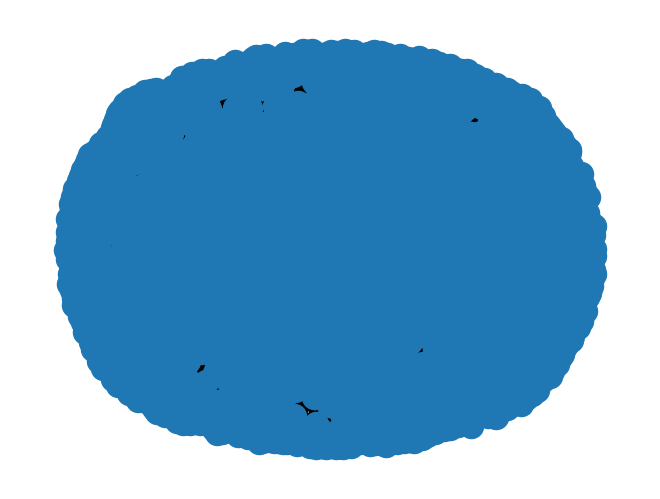

In [72]:
nx.draw(gameGraph)